In [2]:
import numpy as np
from numpy import sin, cos, pi, sqrt
from numpy.linalg import inv
import matplotlib.pyplot as plt
import control as ct
import cv2
import time
from PIL import Image
import os

In [3]:
outputInterval=1/12
playbackSpeed=2
gif=[]
feedbackInterval=0.001
feedbackNumber=max(1,round(outputInterval/feedbackInterval))
feedbackInterval=outputInterval/feedbackNumber
last_update_time=time.time()
WINDOW_NAME="Test"
cv2.namedWindow(WINDOW_NAME)
windowH,windowW,imageScale=500,500,200
R=0.15
v=0.2
x,y,theta=-0.2,-0.2,0
yhat,thetahat=0,0
Pk=np.diag([1,1])
thetadot=0.0
outputHat=[[yhat,thetahat]]
outputThetadot=[thetadot]
z=0
# state: y, theta
A=np.array([
    [0,v],
    [0,0]
])
B=np.array([[0],[1]])
# if line is xAxis, then output=R*tan(theta)+y/cos(theta)
C=np.array([[1,R]])
F=np.identity(2)+A*feedbackInterval
G=B*feedbackInterval
H=C
timeVector=np.linspace(0,outputInterval,feedbackNumber)
# QN=np.diag([0.0001,0.0001])*feedbackInterval
QN=np.diag([0.000001,0.000001])*feedbackInterval
sensorSpacing=0.02
sensorMaxDistance=0.07
RN=np.diag([1/12*(sensorSpacing)**2])
Kr,_,_=ct.lqr(A,B,np.diag([100,0.01]),0.1) # if R=0.15
# Kr,_,_=ct.lqr(A,B,np.diag([1000,0.01]),0.1) # if R=0.1
eigenValue=np.linalg.eig(A-B@Kr)[0]
print('eigen value: ',eigenValue)

errorIntegral=0
preError=0
# lineList=[
#     # point1, point2
#     (np.array([[-0.3],[-0.2]]),np.array([[0.8],[-0.2]])),
#     (np.array([[-0.3],[0.2]]),np.array([[0.8],[0.2]])),
# ]
# curveList=[
#     # centerOfCircle, radiusOfCircle, phaseLow, phaseHigh
#     (np.array([[0.8],[0.]]),0.2,-pi/2,pi/2),
#     (np.array([[-0.3],[0.]]),0.2,pi/2,3*pi/2),
# ]
lineList=[
    # point1, point2
    (np.array([[-0.3],[-0.2]]),np.array([[0],[-0.2]])),
    (np.array([[0.4],[1.2]]),np.array([[-0.3],[1.2]])),
    (np.array([[-0.5],[1]]),np.array([[-0.5],[0]])),
]
curveList=[
    # centerOfCircle, radiusOfCircle, phaseLow, phaseHigh
    (np.array([[0],[0]]),0.2,-pi/2,0),
    (np.array([[0.4],[0]]),0.2,pi/2,pi),
    (np.array([[0.4],[0.7]]),0.5,-pi/2,pi/2),
    (np.array([[-0.3],[1]]),0.2,pi/2,pi),
    (np.array([[-0.3],[0]]),0.2,pi,3*pi/2),
]

imgMap = np.zeros((windowH,windowW, 3), np.uint8)
origin=np.array([[windowW/2-50,windowH/2+100]])
for point1,point2 in lineList:
    point1=(point1*np.array([[1],[-1]])*imageScale+origin.reshape((2,1))).astype(np.int64)
    point2=(point2*np.array([[1],[-1]])*imageScale+origin.reshape((2,1))).astype(np.int64)
    cv2.line(imgMap,(point1[0,0],point1[1,0]),(point2[0,0],point2[1,0]),(255,255,255),3)

curves=[]
for centerOfCircle,radiusOfCircle,phaseLow,phaseHigh in curveList:
    curve=[]
    for angle in np.linspace(phaseLow,phaseHigh,17):
        curve.append(radiusOfCircle*np.array([cos(angle),-sin(angle)]))
    curve=np.array(curve)
    curve=((curve+(centerOfCircle.reshape((1,2)))*np.array([[1,-1]]))*imageScale+origin).astype(np.int64)
    curves.append(curve.copy())
cv2.polylines(imgMap, curves,False,(255,255,255), 3)

def Distance(x,y,theta):
    z_temp=float('inf')
    for point1,point2 in lineList:
        z_temp2=DistanceToLine(x,y,theta,point1,point2)
        if np.abs(z_temp2)<np.abs(z_temp):
            z_temp=z_temp2
    for centerOfCircle,radiusOfCircle,phaseLow,phaseHigh in curveList:
        z_temp2=DistanceToCircle(x,y,theta,centerOfCircle,radiusOfCircle,phaseLow,phaseHigh)
        if np.abs(z_temp2)<np.abs(z_temp):
            z_temp=z_temp2
    return z_temp
def DistanceToLine(x,y,theta,point1,point2):
    lineVector=point2-point1
    lineLength=sqrt(np.sum(lineVector**2))
    lineVector/=lineLength
    normal=np.array([[-lineVector[1,0],lineVector[0,0]]])
    offset=np.array([
        [x+R*cos(theta)-0],
        [y+R*sin(theta)-0]
    ])-point1
    vector=np.array([
        [sin(theta)],
        [-cos(theta)]
    ])
    # normal@(offset+vector*z)=0
    z_temp=(-(normal@offset)[0,0])/((normal@vector)[0,0])
    measuredPoint=offset+vector*z_temp
    measuredLength=(measuredPoint.T@lineVector)[0,0]
    if 0<measuredLength<lineLength:
        return z_temp
    else:
        return float('inf')
def DistanceToCircle(x,y,theta,centerOfCircle,radiusOfCircle,phaseLow,phaseHigh):
    offset=np.array([
        [x+R*cos(theta)],
        [y+R*sin(theta)]
    ])-centerOfCircle
    vector=np.array([
        [sin(theta)],
        [-cos(theta)]
    ])
    # (offset+vector*z)**2=radiusOfCircle**2
    a=1
    b=2*(offset.T@vector)[0,0]
    c=(offset.T@offset)[0,0]-radiusOfCircle**2
    delta=b**2-4*a*c
    if delta<0:
        return float('inf')
    z_temp1=(-b+sqrt(delta))/(2*a)
    z_temp2=(-b-sqrt(delta))/(2*a)
    measuredPoint1=offset+vector*z_temp1
    phase1=np.arctan2(measuredPoint1[1,0],measuredPoint1[0,0])
    if not((phaseLow<phase1<phaseHigh) or (phaseLow<(phase1+2*pi)<phaseHigh) or (phaseLow<(phase1-2*pi)<phaseHigh)):
        z_temp1=float('inf')
    measuredPoint2=offset+vector*z_temp2
    phase2=np.arctan2(measuredPoint2[1,0],measuredPoint2[0,0])
    if not((phaseLow<phase2<phaseHigh) or (phaseLow<(phase2+2*pi)<phaseHigh) or (phaseLow<(phase2-2*pi)<phaseHigh)):
        z_temp2=float('inf')
    if np.abs(z_temp1)<np.abs(z_temp2):
        return z_temp1
    else:
        return z_temp2
def UpdateAnimation(imgMap,origin):
    img=imgMap.copy()

    contours=[]
    offset=(np.array([[x,-y]])*imageScale+origin)%np.array([[windowW,windowH]])
    rect = np.array([
        [R*imageScale,0],
        [0,-20],
        [0,20],
    ])
    Rotation=np.array([
        [cos(theta),-sin(theta)],
        [sin(theta),cos(theta)]
    ])
    rect=(rect@Rotation+offset).astype(np.int64)
    contours.append(rect)
    cv2.drawContours(img, contours, -1, (0,255,0), -1, cv2.LINE_AA)

    measureLine=np.array([
        [R,0],
        [R,z],
    ])*imageScale
    measureLine=(measureLine@Rotation+offset).astype(np.int64)
    cv2.line(img,(measureLine[0,0],measureLine[0,1]),(measureLine[1,0],measureLine[1,1]),(0,0,255),5)
    cv2.imshow(WINDOW_NAME, img)
    return img

UpdateAnimation(imgMap,origin)
while True:
    current_time = time.time()
    if (current_time - last_update_time) >= (outputInterval/playbackSpeed):
        noiseQN=ct.white_noise(timeVector,QN,dt=feedbackInterval).T
        for feedbackIndex in range(feedbackNumber):
            x,y,theta=x+v*cos(theta)*feedbackInterval,y+v*sin(theta)*feedbackInterval,theta+thetadot*feedbackInterval
            y+=noiseQN[feedbackIndex,0]
            theta+=noiseQN[feedbackIndex,1]
            ztemp=Distance(x,y,theta)
            if ztemp!=float('inf'):
                z=ztemp
            z=round(z/sensorSpacing)*sensorSpacing

            if np.abs(z)<sensorMaxDistance:
                # kalman filter
                xhat=np.array([[yhat],[thetahat]])
                xcheck=F@xhat+G*thetadot
                Pcheck=F@Pk@F.T+QN
                K=Pcheck@H.T@inv(H@Pcheck@H.T+np.identity(H.shape[0])*RN)
                xhat=xcheck+K@(z-H@xcheck)
                Pk=(np.identity(F.shape[0])-K@H)@Pcheck
                yhat,thetahat=xhat.ravel()
                # # this will limit thetahat within a range.
                # # Without the constraint the robot still works fine, but the thetaHat shift as robot rotating.
                # # adding constraint cause the thetadot being more "noisy", but it seems fine.
                # if thetahat>0.5 or thetahat<-0.5:
                #     yhat+=thetahat*R
                #     thetahat=0
                
                thetadot=(-Kr@np.array([[yhat],[thetahat]]))[0,0]
            else:
                xhat=np.array([[yhat],[thetahat]])
                xhat=F@xhat+G*thetadot
                Pk=F@Pk@F.T+QN
                yhat,thetahat=xhat.ravel()
                thetadot=(-Kr@np.array([[yhat],[thetahat]]))[0,0]
        img=UpdateAnimation(imgMap,origin)
        gif.append(Image.fromarray(img[...,::-1]))
        outputHat.append([yhat,thetahat])
        outputThetadot.append(thetadot)
        last_update_time = current_time
    key = cv2.waitKey(1) & 0xFF
    if key == 27:  # ESC key
        break
cv2.destroyAllWindows()
outputHat=np.array(outputHat)
outputThetadot=np.array(outputThetadot)
timeVector=np.linspace(0,outputInterval*(outputHat.shape[0]-1),outputHat.shape[0])
exportFileName='./gif/LineFollower.gif'
dir_path="/".join(exportFileName.split('/')[:-1])
if not os.path.exists(dir_path):
    os.makedirs(dir_path)
gif[0].save(exportFileName, save_all=True, append_images=gif[1:], duration=round(outputInterval*1000), loop=0, disposal=0)

eigen value:  [-1.78529484+1.7712362j -1.78529484-1.7712362j]


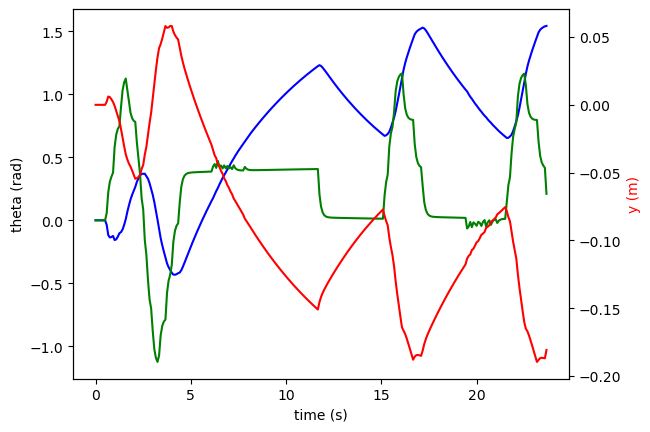

In [35]:
plt.plot(timeVector,outputHat[:,1],'b',label='theta')
plt.plot(timeVector,outputThetadot,'g',label='thetadot')
plt.xlabel('time (s)')
plt.ylabel('theta (rad)')
rightax=plt.twinx()
rightax.plot(timeVector,outputHat[:,0],'r',label='y')
rightax.set_ylabel('y (m)')
rightax.yaxis.label.set_color('red')
plt.show()